🎬 [Start] 하이브리드 AI 광고 생성 시작 (어린이집 컨셉)

🚀 [Phase 1] 누끼 작업 시작...
🧹 [Memory] VRAM Cleaned.
🧹 [Memory] VRAM Cleaned.

🚀 [Phase 2] 배경 생성 시작 (어린이집 컨셉)...
🧹 [Memory] VRAM Cleaned.


100%|██████████| 40/40 [00:15<00:00,  2.67it/s]


🧹 [Memory] VRAM Cleaned.

🚀 [Phase 3] 파이썬 합성 및 텍스트 배치 (위치 조정)...

🚀 [Phase 4] AI 통합 리터칭 (아이와 아기자기한 효과 추가)...
🧹 [Memory] VRAM Cleaned.


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


🧹 [Memory] VRAM Cleaned.


/tmp/ipykernel_89678/3980796335.py:63: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_89678/3980796335.py:63: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_89678/3980796335.py:63: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_89678/3980796335.py:63: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_89678/3980796335.py:63: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_89678/3980796335.py:63: UserWarning: Glyph 47536 (\N{HANGUL SYLLABLE RIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_89678/3980796335.py:63: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt

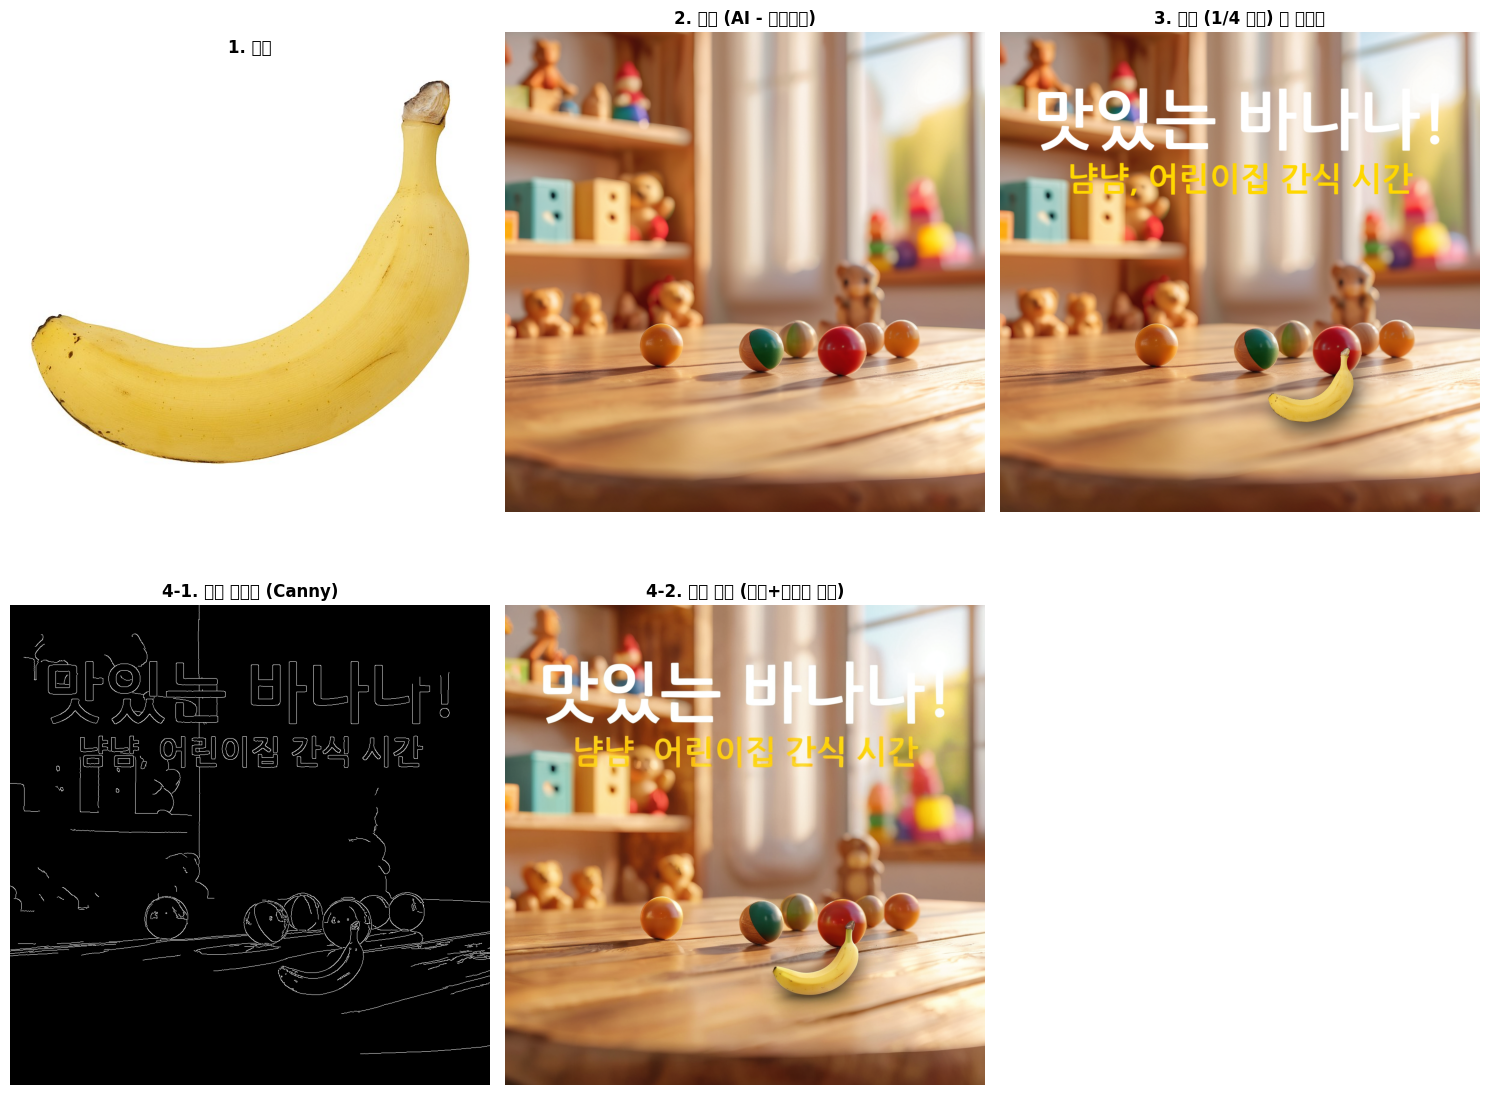

In [2]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import cv2
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from diffusers import (
    StableDiffusionXLControlNetImg2ImgPipeline,
    ControlNetModel,
    AutoencoderKL,
    AutoPipelineForText2Image,
    DPMSolverMultistepScheduler
)
from diffusers.utils import load_image
import matplotlib.pyplot as plt
import math

# ==========================================
# ⚙️ 설정 (이전과 동일)
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.float16
MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "BASE": "RunDiffusion/Juggernaut-XL-v9",
    "VAE": "madebyollin/sdxl-vae-fp16-fix",
    "CONTROLNET": "diffusers/controlnet-canny-sdxl-1.0"
}

def flush():
    gc.collect()
    torch.cuda.empty_cache()
    print("🧹 [Memory] VRAM Cleaned.")

def download_font(font_name="NanumGothicBold.ttf"):
    url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
    if not os.path.exists(font_name) or os.path.getsize(font_name) < 1000:
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def get_canny_edge(image):
    image = np.array(image)
    image = cv2.Canny(image, 50, 150) 
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    return Image.fromarray(image)

def plot_steps(step_images):
    n = len(step_images)
    cols = 3
    rows = math.ceil(n / cols)
    plt.figure(figsize=(15, 6 * rows))
    for i, (img, title) in enumerate(step_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(title, fontsize=12, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==========================================
# 🛠️ [Phase 1] 객체 누끼 (동일)
# ==========================================
def run_segmentation(image_path):
    print("\n🚀 [Phase 1] 누끼 작업 시작...")
    flush()
    model = AutoModelForImageSegmentation.from_pretrained(
        MODEL_IDS["SEG"], trust_remote_code=True
    )
    model.to(DEVICE)
    model.eval()

    img = load_image(image_path).convert("RGB")
    W, H = img.size
    img_input = img.resize((1024, 1024), Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img_input).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = model(input_tensor)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 120 else 0)
    foreground = img.copy()
    foreground.putalpha(mask)
    del model, input_tensor
    flush()
    return img, foreground, mask

# ==========================================
# 🛠️ [Phase 2] 배경 생성 (수정됨: 어린이집)
# ==========================================
def run_bg_generation():
    print("\n🚀 [Phase 2] 배경 생성 시작 (어린이집 컨셉)...")
    flush()
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["VAE"], torch_dtype=TORCH_DTYPE).to(DEVICE)
    pipe = AutoPipelineForText2Image.from_pretrained(
        MODEL_IDS["BASE"], torch_dtype=TORCH_DTYPE, variant="fp16", vae=vae
    ).to(DEVICE)
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)
    
    # 💡 수정된 프롬프트: 어린이집 식탁, 따뜻한 분위기
    prompt = (
        "Professional photography, macro shot, small rustic wooden child's table surface, "
        "blurred warm sunlit daycare center background, colorful toys in bokeh, "
        "soft golden hour light, cozy atmosphere, highly detailed, 8k"
    )
    negative = "messy, cluttered, dark, text, watermark, adult furniture"
    
    bg = pipe(
        prompt=prompt, negative_prompt=negative,
        width=1024, height=1024, num_inference_steps=40, guidance_scale=7.0
    ).images[0]
    del pipe, vae
    flush()
    return bg

# ==========================================
# 🛠️ [Phase 3] 파이썬 합성 & 텍스트 배치 (수정됨: 크기/위치/폰트)
# ==========================================
def run_manual_composition(bg, fg, mask):
    print("\n🚀 [Phase 3] 파이썬 합성 및 텍스트 배치 (위치 조정)...")
    
    # 1. 객체 합성 (크기 1/4로 축소, 위치 변경)
    bg_w, bg_h = bg.size
    fg_w, fg_h = fg.size
    scale = 0.25 # 🔥 1/4 크기로 축소
    new_w, new_h = int(fg_w * scale), int(fg_h * scale)
    
    fg_resized = fg.resize((new_w, new_h), Image.LANCZOS)
    mask_resized = mask.resize((new_w, new_h), Image.LANCZOS)
    
    # 객체 위치 (아이 손이 닿을 듯한 오른쪽 하단으로 이동)
    obj_x = int(bg_w * 0.55)
    obj_y = int(bg_h * 0.65)
    
    shadow = Image.new("RGBA", bg.size, (0,0,0,0))
    shadow.paste((0,0,0,180), (obj_x+10, obj_y+15), mask=mask_resized)
    shadow = shadow.filter(ImageFilter.GaussianBlur(20))
    
    comp = bg.convert("RGBA")
    comp = Image.alpha_composite(comp, shadow)
    fg_layer = Image.new("RGBA", bg.size, (0,0,0,0))
    fg_layer.paste(fg_resized, (obj_x, obj_y), mask=fg_resized)
    comp = Image.alpha_composite(comp, fg_layer)
    
    # 2. 텍스트 배치 (아기자기하고 굵게, 상단으로 이동)
    draw = ImageDraw.Draw(comp)
    font_path = download_font()
    
    main_text = "맛있는 바나나!"
    sub_text = "냠냠, 어린이집 간식 시간"
    
    # 폰트 크기 키움 (아기자기하고 굵은 느낌을 위해)
    font_main = ImageFont.truetype(font_path, 140)
    font_sub = ImageFont.truetype(font_path, 70)
    
    def get_pos(text, font, y_offset):
        bbox = draw.textbbox((0,0), text, font=font)
        w = bbox[2] - bbox[0]
        return ((bg_w - w) // 2, y_offset)

    draw.text(get_pos(main_text, font_main, 120), main_text, font=font_main, fill="white")
    draw.text(get_pos(sub_text, font_sub, 280), sub_text, font=font_sub, fill="#FFD700")
    
    return comp.convert("RGB")

# ==========================================
# 🛠️ [Phase 4] AI 통합 리터칭 (수정됨: 아이와 아기자기한 텍스트)
# ==========================================
def run_final_refinement(composite_image):
    print("\n🚀 [Phase 4] AI 통합 리터칭 (아이와 아기자기한 효과 추가)...")
    flush()
    
    canny_map = get_canny_edge(composite_image)
    
    controlnet = ControlNetModel.from_pretrained(MODEL_IDS["CONTROLNET"], torch_dtype=TORCH_DTYPE).to(DEVICE)
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["VAE"], torch_dtype=TORCH_DTYPE).to(DEVICE)
    pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
        MODEL_IDS["BASE"], controlnet=controlnet, vae=vae, torch_dtype=TORCH_DTYPE, variant="fp16"
    ).to(DEVICE)
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)
    
    # 💡 수정된 프롬프트: 아이가 손을 뻗는 상황극 + 아기자기한 3D 텍스트
    prompt = (
        "Professional photography, a cute 5-year-old child's chubby hand reaching out "
        "to grab a small banana on a rustic wooden table in a daycare. Warm sunlight, expressive. "
        "3d rendered playful cartoon text, bubble font, glowing, bold and cute typography, " # 아기자기한 텍스트 효과
        "golden outlines, high quality, 8k"
    )
    negative = "low quality, blur, distortion, ugly, messy text, adult hands, scary"
    
    final = pipe(
        prompt=prompt,
        negative_prompt=negative,
        image=composite_image,
        control_image=canny_map,
        # strength를 약간 올려서 아이 손을 더 자연스럽게 생성하도록 유도
        strength=0.4,                 
        controlnet_conditioning_scale=1.0,
        num_inference_steps=50,
        guidance_scale=8.0
    ).images[0]
    
    del pipe, controlnet, vae
    flush()
    return final, canny_map

# ==========================================
# 🚀 메인 파이프라인
# ==========================================
def process_hybrid_ad(image_path):
    print("🎬 [Start] 하이브리드 AI 광고 생성 시작 (어린이집 컨셉)")
    step_images = []
    
    # 1. 누끼
    orig, fg, mask = run_segmentation(image_path)
    step_images.append((orig, "1. 원본"))
    
    # 2. 배경 (어린이집)
    bg = run_bg_generation()
    step_images.append((bg, "2. 배경 (AI - 어린이집)"))
    
    # 3. 파이썬 합성 (바나나 1/4 크기, 텍스트 상단)
    draft_comp = run_manual_composition(bg, fg, mask)
    step_images.append((draft_comp, "3. 배치 (1/4 크기) 및 텍스트"))
    
    # 4. 최종 리터칭 (아이가 먹으려는 장면 + 아기자기한 텍스트)
    final_result, canny = run_final_refinement(draft_comp)
    step_images.append((canny, "4-1. 형태 가이드 (Canny)"))
    step_images.append((final_result, "4-2. 최종 결과 (아이+텍스트 효과)"))
    
    final_result.save("final_kids_ad.png")
    plot_steps(step_images)

# 실행
process_hybrid_ad("image.png")